In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import spacy
import gensim
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.corpora.dictionary import Dictionary
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.models.ldamodel import LdaModel
#from gensim.test.utils import common_corpus, common_dictionary
import os

# read corpus from csv
train = pd.read_csv(r"/users/wangp/work/mypython/train.csv")
# Set Column Names 
train.columns = ['ClassIndex', 'Title', 'Description']
# Combine Title and Description
# Because better accuracy than using them as separate features
X_train = train['Title'] + " " + train['Description'] 
doc_list = X_train[0:99].tolist() # only use 100 documents

print(doc_list[0:2])
# prepare data
nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
stop_words = stopwords.words('english')

def save_model(lda_model,num):      
    #lda_ml = LDA(corpus=BoW_corpus, dictionary=dictionary,k_topic=6)
    lda_model.save(os.path.join('save_model','first_topic_model_'+str(num)))
#    print("Saved model")
    
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True))

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    [trigram_mod[bigram_mod[doc]] for doc in texts]


data_words = list(sent_to_words(doc_list))

bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

data_words_nostops = remove_stopwords(data_words)

data_words_bigrams = make_bigrams(data_words_nostops)
#data_words_trigrams = make_trigrams(data_words_nostops)
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=[
   'NOUN', 'ADJ', 'VERB', 'ADV'
])

#print(data_lemmatized[0:2])
#doc_tokenized = [simple_preprocess(doc) for doc in doc_list]
dictionary = corpora.Dictionary(data_lemmatized)
#BoW_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in doc_tokenized]
texts = data_lemmatized
BoW_corpus = [dictionary.doc2bow(text) for text in texts]

#if need to save corpus
#import pickle
#with open("corpus.pkl", "wb") as f:
#    pickle.dump(BoW_corpus, f) 
#with open("corpus_2.pkl", "wb") as f:
#    pickle.dump(BoW_corpus, f)     

iterations = 5
save_file = True
Topics = 5
   
for i in range(iterations):
        
    #id_words = [[(dictionary[id], count) for id, count in line] for line in BoW_corpus]
    lda_model = LdaModel(
       corpus=BoW_corpus, id2word=dictionary, num_topics=Topics, #random_state=100, 
       update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True
    )
    if save_file: 
        save_model(lda_model, i)

#    print('\nPerplexity: ', lda_model.log_perplexity(BoW_corpus))
    #print([ lda_model.get_topic_terms(tid, topn=3) for tid in range(2) ])
    # print each model's topic words
    #print([ [(dictionary[wid], s) for (wid, s) in lda_model.get_topic_terms(tid, topn=25)] for tid in range(Topics)])
    my_dict = {'Topic_' + str(i): [token for token, score in lda_model.show_topic(i, topn=25)] for i in range(0, lda_model.num_topics)}
    print(my_dict)
print("End")    

["Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.']


[nltk_data] Downloading package stopwords to
[nltk_data]     /users/wangp/work/nltk_data/...
[nltk_data]   Package stopwords is already up-to-date!


{'Topic_0': ['offering', 'growth', 'get', 'interview', 'public', 'turn', 'company', 'say', 'start', 'com', 'trade', 'search', 'auction', 'deficit', 'slow', 'go', 'gene', 'report', 'workaholic', 'quality', 'interest', 'quarter', 'rate', 'bank', 'drive'], 'Topic_1': ['oil', 'new', 'price', 'record', 'economy', 'stock', 'market', 'outlook', 'time', 'blue', 'customer', 'say', 'crude', 'could', 'soar', 'pay', 'show', 'today', 'technology', 'fall', 'look', 'week', 'main', 'pipeline', 'southern'], 'Topic_2': ['firm', 'cut', 'job', 'short', 'also', 'buy', 'wireless', 'share', 'fall', 'say', 'take', 'new', 'rate', 'market', 'beat', 'turn', 'skill', 'dwindle', 'green', 'black', 'seeing', 'ultra', 'seller', 'cynic', 'company'], 'Topic_3': ['company', 'new', 'good', 'money', 'mail', 'technology', 'market', 'say', 'software', 'week', 'grow', 'fund', 'late', 'sale', 'show', 'include', 'product', 'year', 'destination', 'alligator', 'employee', 'tourism', 'head', 'science', 'russian'], 'Topic_4': ['sa

In [27]:
# Calculate JS distance between each pair of models
from gensim.models.ldamulticore import LdaMulticore
from gensim.test.utils import datapath
diff_list = []
diff_pair = []
diff_num = []
for i in range(iterations-1):
    for j in range(i+1, iterations):
        #print(str(i), str(j))
        m1 = LdaMulticore.load(os.path.join('save_model','first_topic_model_'+str(i)))
        m2 = LdaMulticore.load(os.path.join('save_model','first_topic_model_'+str(j)))
        mdiff2, annotation2 = m1.diff(m2, distance='jensen_shannon')
        #print(mdiff2) # 5x5
        diff_num.append(str(i)+":"+str(j))
        diff_pair.append("Model " +str(i) + " vs. Model " + str(j))
        diff_list.append(mdiff2)        
        #print(annotation2[0,0])

In [28]:
import networkx as nx
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import min_weight_full_bipartite_matching
# one pair of models, bipartite matching
#t_size = 2*Topics
#multi_matrix = np.zeros((t_size,t_size),dtype=float) 
#multi_matrix.reshape((iterations-1)*Topics,(iterations-1)*Topics)
#print(multi_matrix.shape)

for i in range(len(diff_list)):
#    multi_matrix[0:Topics, Topics:(2*Topics)] = diff_list[i]
#    multi_matrix[Topics:(2*Topics), 0:Topics] = diff_list[i]

    #print(multi_matrix)
    graph = csr_matrix(diff_list[i])
    print(diff_pair[i])
#    print(min_weight_full_bipartite_matching(graph))
    row_ind, col_ind = min_weight_full_bipartite_matching(graph)
    for j in range(row_ind.size):
        print('topic %s - topic %s : %s' % (row_ind[j]%Topics, col_ind[j]%Topics, graph[row_ind[j], col_ind[j]]))
        if (row_ind[j]%Topics == Topics-1):
            print("===============================================")


Model 0 vs. Model 1
topic 0 - topic 4 : 0.8821409593781698
topic 1 - topic 2 : 0.7209585236548973
topic 2 - topic 0 : 0.7005122131469305
topic 3 - topic 3 : 0.734595619050841
topic 4 - topic 1 : 0.7337068360608788
Model 0 vs. Model 2
topic 0 - topic 0 : 0.7532174207987671
topic 1 - topic 2 : 0.7236310252336995
topic 2 - topic 3 : 0.6755889888231341
topic 3 - topic 4 : 0.7731819293449625
topic 4 - topic 1 : 0.8150090715940927
Model 0 vs. Model 3
topic 0 - topic 1 : 0.7985103148890845
topic 1 - topic 4 : 0.8007350176002467
topic 2 - topic 3 : 0.6639100343596056
topic 3 - topic 2 : 0.8124051811529037
topic 4 - topic 0 : 0.7388544423396298
Model 0 vs. Model 4
topic 0 - topic 3 : 0.7999778556331953
topic 1 - topic 2 : 0.6708279264529143
topic 2 - topic 0 : 0.5534125063677587
topic 3 - topic 1 : 0.7923959166417853
topic 4 - topic 4 : 0.6464838763298706
Model 1 vs. Model 2
topic 0 - topic 0 : 0.771714019013465
topic 1 - topic 1 : 0.7006567750542317
topic 2 - topic 4 : 0.6928143555532675
topic

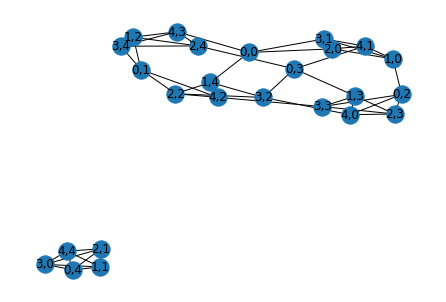

['1,0', '2,0', '4,1', '3,1']
['3,3', '2,3', '0,2']
['3,3', '2,3', '1,3']
['1,1', '3,0', '0,4', '4,4', '2,1']
['2,0', '0,0', '3,1']
['4,0', '2,3', '0,2']
['4,0', '2,3', '1,3']
['4,2', '2,2', '0,1']
['4,2', '2,2', '1,4']
['2,2', '3,2', '1,4']
['1,2', '3,4', '0,1']
['1,2', '3,4', '2,4', '4,3']
clique number: 12


In [29]:
# define Maxmum edges the clique includes
# default is 3
# if the iteration is large, there will be many cliques
Max_num_clique = 3

G = nx.Graph()

for i in range(len(diff_list)):
    graph = csr_matrix(diff_list[i])
    row_ind, col_ind=min_weight_full_bipartite_matching(graph)
#    print(diff_pair[i])
#    print(row_ind, col_ind)
    
    num_list = diff_num[i].split(":")
    start_model_num = int(num_list[0])
    end_model_num = int(num_list[1])
    for j in range(row_ind.size):
        #print('topic %s - topic %s : %s' % (row_ind[i]%Topics, col_ind[i]%Topics, graph[row_ind[i], col_ind[i]]))
        #if (row_ind[i]%Topics == Topics-1):
        nodes1 = str(start_model_num)+","+str(row_ind[j])
        nodes2 = str(end_model_num)+","+str(col_ind[j])
#        print(graph[row_ind[j], col_ind[j]])
        G.add_edge(nodes1, nodes2, weight=graph[row_ind[j], col_ind[j]])
        
#layout = nx.spring_layout(G)
nx.draw(G, with_labels = True)
#nx.draw_networkx_edge_labels(G, pos=layout)
plt.show()

from networkx.algorithms import clique
cg = list(clique.find_cliques(G))
#print(len(cg))
#from networkx.algorithms.approximation import clique
#print(clique.max_clique(G))

count = 0
for i in range(len(cg)):
    if (len(cg[i]) >= Max_num_clique):
#        print(i)
        print(cg[i])
        count += 1
#        nx.draw(cg[i], with_labels = True)
print("clique number: " + str(count))

In [89]:
all_node = set()
for i in range(len(cg)):
    all_node = set.union(all_node,set(cg[i]))
print(len(all_node))    

50


In [14]:
# print clique weight

for k in range (len(cg)):
    if (len(cg[k]) >= Max_num_clique):
        print(cg[k])
        sum_weight = 0
        for i in range(len(cg[k])):
            if (i == len(cg[k])-1):
                print(cg[k][0]+"-"+cg[k][i]+": "+str(G.get_edge_data(cg[k][0],cg[k][i])['weight'])) 
                sum_weight += float(G.get_edge_data(cg[k][0],cg[k][i])['weight'])
            else:    
                print(cg[k][i]+"-"+cg[k][i+1]+": "+str(G.get_edge_data(cg[k][i],cg[k][i+1])['weight']))
                sum_weight += float(G.get_edge_data(cg[k][0],cg[k][i+1])['weight'])
        print(sum_weight)

['1,0', '2,3', '3,0']
1,0-2,3: 0.658330266335755
2,3-3,0: 0.7238655079997859
1,0-3,0: 0.7733574994130857
2.2050452651619263
['1,0', '0,4', '4,0']
1,0-0,4: 0.5985611234795055
0,4-4,0: 0.7432928958395998
1,0-4,0: 0.6684975927263789
1.9355563089322634
['3,3', '1,2', '2,4']
3,3-1,2: 0.7203533356271227
1,2-2,4: 0.7559149536617173
3,3-2,4: 0.6001999903857332
1.920753316398589
['3,3', '4,0', '0,4']
3,3-4,0: 0.7460028026721773
4,0-0,4: 0.7432928958395998
3,3-0,4: 0.803729886136074
2.3534625749443254
['1,1', '2,2', '0,2', '3,2']
1,1-2,2: 0.5639037069237297
2,2-0,2: 0.6608002945401137
0,2-3,2: 0.7580943103244141
1,1-3,2: 0.7558342512898157
2.75243368850727
['2,0', '4,0', '0,4']
2,0-4,0: 0.6672113008003909
4,0-0,4: 0.7432928958395998
2,0-0,4: 0.6825867736327224
2.0323848480658357
['2,0', '1,3', '3,4']
2,0-1,3: 0.6151679580462508
1,3-3,4: 0.7608042914820592
2,0-3,4: 0.7118963595681217
2.0389606771824944
['4,1', '0,1', '2,1']
4,1-0,1: 0.6899959845007279
0,1-2,1: 0.6465996414732201
4,1-2,1: 0.470039